# Objective 1 : DICOM loading and visualization

# Step 1 – Import Required Libraries

In [1]:
import os

import matplotlib
import pydicom
import numpy as np
import scipy
from matplotlib import pyplot as plt, animation
import highdicom
from highdicom.seg import Segmentation
from pydicom import dcmread
from pathlib import Path

Helper Functions from the lab for Image Reformatting and Projection for analyzing and visualizing anatomical structures like the liver and tumor from different perspectives.

In [2]:
def median_sagittal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the median sagittal plane of the CT image provided. """
    return img_dcm[:, :, img_dcm.shape[1]//2]   


def median_coronal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the median sagittal plane of the CT image provided. """
    return img_dcm[:, img_dcm.shape[2]//2, :]


def MIP_sagittal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the maximum intensity projection on the sagittal orientation. """
    return np.max(img_dcm, axis=2)


def AIP_sagittal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the average intensity projection on the sagittal orientation. """
    return np.mean(img_dcm, axis=2)


def MIP_coronal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the maximum intensity projection on the coronal orientation. """
    return np.max(img_dcm, axis=1)


def AIP_coronal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the average intensity projection on the coronal orientation. """
    return np.mean(img_dcm, axis=1)


def rotate_on_axial_plane(img_dcm: np.ndarray, angle_in_degrees: float) -> np.ndarray:
    """ Rotate the image on the axial plane. """
    return scipy.ndimage.rotate(img_dcm, angle_in_degrees, axes=(1, 2), reshape=False)

Sets up all the file paths needed to access to the CT image series directory and the DICOM segmentation files for Liver (ManualROI_Liver.dcm) and Tumor (ManualROI_Tumor.dcm)

In [3]:
# Define paths
data_dir = Path('RadCTTACEomics_1015/1015/')
image_dir = data_dir / '11_AP_Ax5.00mm'
liver_seg_path = data_dir / '11_AP_Ax5.00mm_ManualROI_Liver.dcm'
tumor_seg_path = data_dir / '11_AP_Ax5.00mm_ManualROI_Tumor.dcm'

# Step 2 – Load and Sort CT Image Slices

To accurately reconstruct a 3D model, slice order must reflect physical patient orientation. Improper sorting would produce anatomically incorrect volume.
this function will loads 2D DICOM image slices from disk, arranges them into the correct anatomical order based on patient positioning, and then stacks them into a 3D CT volume (volume)

In [4]:
# Load and sort image slices
slices = []
for f in sorted(os.listdir(image_dir)):
    path = image_dir / f
    ds = dcmread(path)
    if hasattr(ds, 'ImagePositionPatient'):
        slices.append((ds.ImagePositionPatient[2], ds))

# Sort by z-location
slices.sort(key=lambda x: x[0])
image_slices = [s[1] for s in slices]

# Create a 3D numpy array
volume = np.stack([s.pixel_array for s in image_slices])

# Get pixel dimensions

Retrieves the physical dimensions of a voxel from a the DICOM image slice. It accesses the first slice in the dataset, extracts the slice thickness (spacing along the Z-axis) and the pixel spacing (size of each pixel in the X and Y directions), and then combines these values into a NumPy array called pixel_dims. This array represents the voxel dimensions in millimeters as [Z, Y, X], which is essential for accurate 3D visualization, volume calculation, and medical image analysis.

In [5]:
# Get pixel dimensions
first_slice_tuple = slices[0]
first_slice = first_slice_tuple[1]  
slice_thickness = float(first_slice.SliceThickness)
pixel_spacing = list(map(float, first_slice.PixelSpacing))
pixel_dims = np.array([slice_thickness] + pixel_spacing)  

print("First Slice:", first_slice)
print("Slice Thickness (mm):", slice_thickness)
print("Pixel Spacing (mm):", pixel_spacing)
print("Pixel Dimensions (Z, Y, X in mm):", pixel_dims)

First Slice: Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 182
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.113619.2.5.4233778292.11369.1421048492.438
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4-JP'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 192'
(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY', 'REFORMATTED', 'AVERAGE']
(0008, 0012) Instance Creation Date              DA: ''
(0008, 0013) Instance Creation Time              TM: '100336'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0017) 

#  Step 3: Load and Parse Segmentations

Segmentations are essential for identifying and analyzing specific anatomical regions. Without these masks, we'd have no clear spatial definition of structures like the liver or tumor in the 3D CT volume, this code load segmentation masks (liver and tumor) from DICOM-SEG files and convert them into NumPy arrays aligned with the CT scan making it possible to overlay, compute volumes and analysis (like tumor growth tracking or visualization)

In [6]:
# Load segmentations
# Reads the raw DICOM-SEG file from disk (dcmread()) and parses it into a structured segmentation object that includes metadata, label info, and the mask data
liver_seg = Segmentation.from_dataset(dcmread(liver_seg_path))
tumor_seg = Segmentation.from_dataset(dcmread(tumor_seg_path))

# Extract the segmentation masks as NumPy arrays
liver_array = liver_seg.pixel_array  
tumor_array = tumor_seg.pixel_array

# Show Slice Thicknesses

useful code for verifying slice spacing and ensuring consistency in the CT scan dataset. 

Slice thickness is important for ensuring uniformity in the CT scan data. Inconsistent slice thickness can lead to misaligned anatomical regions or artifacts in the reconstructed volume and may indicate acquisition issues.
Checking the slice thickness helps verify whether the scan was performed correctly or if there are issues with the acquisition process (slice thickness varies between slices).

In [10]:
def show_slice_thicknesses(image_slices, plot: bool = False):
    """Display the slice thickness for each DICOM slice in the image_slices list."""
    slice_thicknesses = []
    for i, ds in enumerate(image_slices):
        thickness = float(ds.SliceThickness) if hasattr(ds, 'SliceThickness') else None
        slice_thicknesses.append(thickness)
        print(f"Slice {i}: Thickness = {thickness} mm")

    return slice_thicknesses
slice_thicknesses = show_slice_thicknesses(image_slices, plot=True)

Slice 0: Thickness = 5.0 mm
Slice 1: Thickness = 5.0 mm
Slice 2: Thickness = 5.0 mm
Slice 3: Thickness = 5.0 mm
Slice 4: Thickness = 5.0 mm
Slice 5: Thickness = 5.0 mm
Slice 6: Thickness = 5.0 mm
Slice 7: Thickness = 5.0 mm
Slice 8: Thickness = 5.0 mm
Slice 9: Thickness = 5.0 mm
Slice 10: Thickness = 5.0 mm
Slice 11: Thickness = 5.0 mm
Slice 12: Thickness = 5.0 mm
Slice 13: Thickness = 5.0 mm
Slice 14: Thickness = 5.0 mm
Slice 15: Thickness = 5.0 mm
Slice 16: Thickness = 5.0 mm
Slice 17: Thickness = 5.0 mm
Slice 18: Thickness = 5.0 mm
Slice 19: Thickness = 5.0 mm
Slice 20: Thickness = 5.0 mm
Slice 21: Thickness = 5.0 mm
Slice 22: Thickness = 5.0 mm
Slice 23: Thickness = 5.0 mm
Slice 24: Thickness = 5.0 mm
Slice 25: Thickness = 5.0 mm
Slice 26: Thickness = 5.0 mm
Slice 27: Thickness = 5.0 mm
Slice 28: Thickness = 5.0 mm
Slice 29: Thickness = 5.0 mm
Slice 30: Thickness = 5.0 mm
Slice 31: Thickness = 5.0 mm
Slice 32: Thickness = 5.0 mm
Slice 33: Thickness = 5.0 mm
Slice 34: Thickness = 5.

# Extract and Summarize Segmentation Metadata

extract key metadata from the segmentation files and display relevant information about the segmentation dataset. This step provides essential information for understanding the structure and properties of the segmentation, which is important for subsequent analysis and visualization

In [15]:
def get_segmentation_spacing(seg: Segmentation): 
    shared_fg = seg.SharedFunctionalGroupsSequence[0]
    pixel_measures = shared_fg.PixelMeasuresSequence[0]
    pixel_spacing = pixel_measures.PixelSpacing  
    slice_thickness = pixel_measures.SliceThickness
    return float(slice_thickness), float(pixel_spacing[0]), float(pixel_spacing[1])  


In [18]:
def summarize_segmentation(seg: Segmentation, name="Segmentation"):
    spacing = get_segmentation_spacing(seg)
    num_frames = seg.NumberOfFrames
    rows, cols = seg.Rows, seg.Columns
    modality = seg.Modality
    manufacturer = getattr(seg, "Manufacturer", "Unknown")
    series_description = getattr(seg, "SeriesDescription", "N/A")
    
    z_positions = [
        f.PlanePositionSequence[0].ImagePositionPatient[2]
        for f in seg.PerFrameFunctionalGroupsSequence
    ]
    num_unique_slices = len(set(z_positions))

    print(f"--- {name} Summary ---")
    print("Modality:", modality)
    print("Manufacturer:", manufacturer)
    print("Series Description:", series_description)
    print("Spacing (Z, Y, X in mm):", spacing)
    print("Image Size (Rows x Columns):", rows, "x", cols)
    print("Number of Frames (slices):", num_frames)
    print("Unique Z-locations:", num_unique_slices)
    print()


In [20]:
print("Liver SEG Spacing (Z, Y, X in mm):", get_segmentation_spacing(liver_seg))
print("Tumor SEG Spacing (Z, Y, X in mm):", get_segmentation_spacing(tumor_seg))

Liver SEG Spacing (Z, Y, X in mm): (5.0, 0.804688, 0.804688)
Tumor SEG Spacing (Z, Y, X in mm): (5.0, 0.804688, 0.804688)


In [21]:
summarize_segmentation(liver_seg, "Liver SEG")
summarize_segmentation(tumor_seg, "Tumor SEG")

--- Liver SEG Summary ---
Modality: SEG
Manufacturer: None
Series Description: 11_AP_Ax5.00mm_ManualROI_Liver.dcm
Spacing (Z, Y, X in mm): (5.0, 0.804688, 0.804688)
Image Size (Rows x Columns): 512 x 512
Number of Frames (slices): 26
Unique Z-locations: 26

--- Tumor SEG Summary ---
Modality: SEG
Manufacturer: None
Series Description: 11_AP_Ax5.00mm_ManualROI_Tumor.dcm
Spacing (Z, Y, X in mm): (5.0, 0.804688, 0.804688)
Image Size (Rows x Columns): 512 x 512
Number of Frames (slices): 6
Unique Z-locations: 6



# Step 4: Construct Segmentation Volume Aligned to CT

Segmentation objects store 2D frames that may not be ordered or aligned like the original CT slices.

The get_segmentation_volume function reconstructs a 3D segmentation mask that matches the CT volume shape and orientation.

This is important for visual overlays, and 3D visualization.

In [ ]:
def get_segmentation_volume(seg: Segmentation):

    # Get Frame Z-positions from SEG (for each frame (2D slice) in the segmentation, extract the ImagePositionPatient, which represent the 3D spatial location of that slice.)
    frames = seg.PerFrameFunctionalGroupsSequence
    positions = [
        tuple(f.PlanePositionSequence[0].ImagePositionPatient)
        for f in frames
    ]
    # Create Mapping from Z-position to Frame Index (maps each Z-coordinate to the corresponding frame index in the segmentation pixel array. 
    # This helps to insert each frame at the correct depth in the 3D CT volume)
    z_to_index = {pos[2]: i for i, pos in enumerate(positions)}

    # Match CT Z-positions and Create Volume (extract Z-coordinates from the CT image slices (same order used to create volume) and
    # initialize a new segmentation volume with the same shape as the CT volume, filled with zeros) 
    ct_z_positions = [s.ImagePositionPatient[2] for s in image_slices]
    seg_volume = np.zeros_like(volume, dtype=np.uint8)

    # Fill in Segmentation Frames at Correct Slices (for each CT slice, if a segmentation exists at the same Z-coordinate, 
    # insert the corresponding segmentation mask into the 3D array at the right index)
    for i, z in enumerate(ct_z_positions):
        if z in z_to_index:
            seg_volume[i] = seg.pixel_array[z_to_index[z]]

    return seg_volume

In [ ]:
# Rearranging Segmentation Masks to Match CT Volume 

# This code will :
# 1- Aligns the segmentation slices with the CT volume based on Z-position.
# 2- Reconstructs full 3D binary masks (same shape as the CT volume) where the liver and tumor regions are marked.

liver_mask = get_segmentation_volume(liver_seg)
tumor_mask = get_segmentation_volume(tumor_seg)

# The outputs liver_mask and tumor_mask are 3D numpy arrays of shape equal to the original CT volume

# Visualizing CT Slice with Liver and Tumor Segmentation Overlays

display a specific slice of the CT scan with overlaid liver and tumor segmentation masks to aid in visual inspection and analysis of the segmented areas

In [262]:
def show_slice_with_masks(ct_volume, liver_mask, tumor_mask, slice_idx):
    plt.figure(figsize=(12, 6))

    # CT slice
    plt.subplot(1, 3, 1)
    plt.imshow(ct_volume[slice_idx], cmap='gray')
    plt.title(f'CT Slice {slice_idx}')
    plt.axis('off')

    # Liver mask
    plt.subplot(1, 3, 2)
    plt.imshow(ct_volume[slice_idx], cmap='gray')
    plt.imshow(liver_mask[slice_idx], cmap='Reds', alpha=0.4)
    plt.title('Liver Segmentation Overlay')
    plt.axis('off')

    # Tumor mask
    plt.subplot(1, 3, 3)
    plt.imshow(ct_volume[slice_idx], cmap='gray')
    plt.imshow(tumor_mask[slice_idx], cmap='Blues', alpha=0.4)
    plt.title('Tumor Segmentation Overlay')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

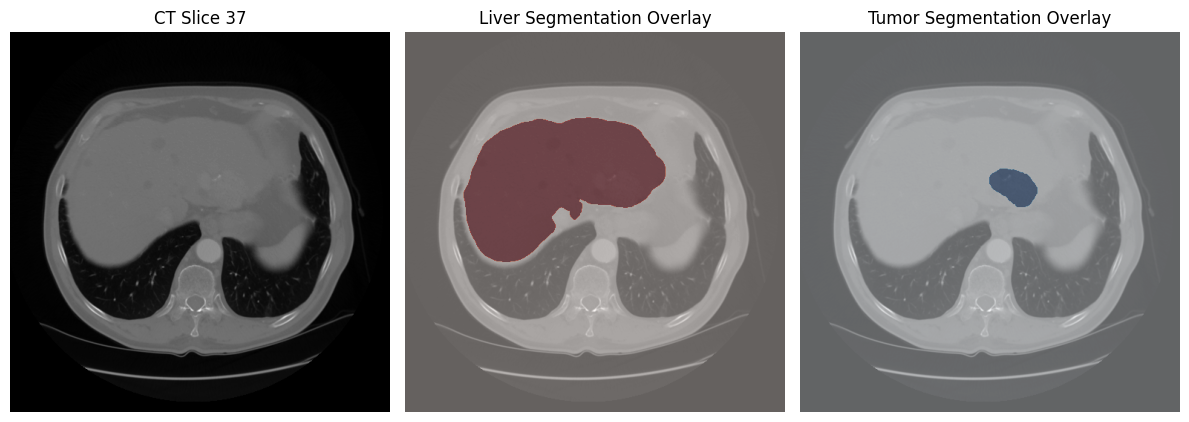

In [263]:
slice_idx =  37
show_slice_with_masks(volume, liver_mask, tumor_mask, slice_idx)

# Step 5: Fusing CT with Segmentations for Visualization

the fuse_ct_with_segmentations function is implemented to visualize the segmented regions (liver and tumor) overlaid on the CT slices.
The output is a fused RGB volume (array of images)

In [ ]:
def fuse_ct_with_segmentations(ct_volume: np.ndarray, masks: dict, colors: dict = None, ct_opacity: float = 0.8, mask_opacity: float = 0.2 ) -> np.ndarray:

    fused_slices = []
    cmap = matplotlib.colormaps['bone']

    # Loop over slices (Z axis)
    for i in range(ct_volume.shape[0]):

        # for visualization consistency normalization is applied globally using the entire CT volume's min and max, not just the current slice
        # each individual slice is normalized using the same intensity range (from the entire volume)
        # This ensures consistent contrast across all slices when visualized.
        # Brightness and contrast would vary from slice to slice, this would make it harder to visually compare structures between slices in a consistent way
        norm = matplotlib.colors.Normalize(vmin=np.min(ct_volume), vmax=np.max(ct_volume))
        
        # Convert to RGB image 
        ct_rgb = cmap(norm(ct_volume[i]))[..., :3] 
        
        # Start with grayscale CT image
        fused = ct_rgb.copy() 

        for name, mask in masks.items():
            color = colors.get(name, (1, 1, 1))  
            mask_rgb = np.stack([mask[i] * c for c in color], axis=-1)

            # Add mask on top of CT slice
            fused +=  mask_rgb 

        fused = np.clip(fused, 0, 1)
        
        # Save the slice
        fused_slices.append(fused)

    return np.array(fused_slices)

In [ ]:
# Fuse the CT volume with segmentation masks into color-overlaid slices
fused_volume = fuse_ct_with_segmentations(
    # 3D CT scan (grayscale)
    ct_volume=volume,
    # Dict of masks to overlay 
    masks={'liver': liver_mask, 'tumor': tumor_mask}, 
    # RGB colors per mask
    colors={'liver': (0.5, 0, 0), 'tumor': (0, 0.5, 0)},  
    ct_opacity=0.8,
    mask_opacity=0.2
)

# Displaying Fused CT Slice with Liver and Tumor Masks

combines CT scan data with the corresponding segmentation masks and visualizes them to provide a clearer view of the anatomical regions of interest (liver and tumor).

In [ ]:
masks = {
    "liver": liver_mask,
    "tumor": tumor_mask
}

colors = {
    "liver": (0.5, 0, 0),  
    "tumor": (0, 0.5, 0)    
}

fused_slices = fuse_ct_with_segmentations(volume, masks, colors)
plt.imshow(fused_slices[36])
plt.title("Fused Slice with Liver & Tumor")
plt.axis("off")
plt.show()

# Step 6: Visualization of Sagittal and coronal Planes using Median, MIP, and AIP Projections

This step helps visualize the anatomy and segmentations from the sagittal view (side view) and provides different intensity-based projections.

This step helps in visualizing internal structures in different ways:

1- Median plane shows a representative slice.

2- MIP enhances bright structures (for detecting tumors).

3- AIP smooths out details for average tissue view.

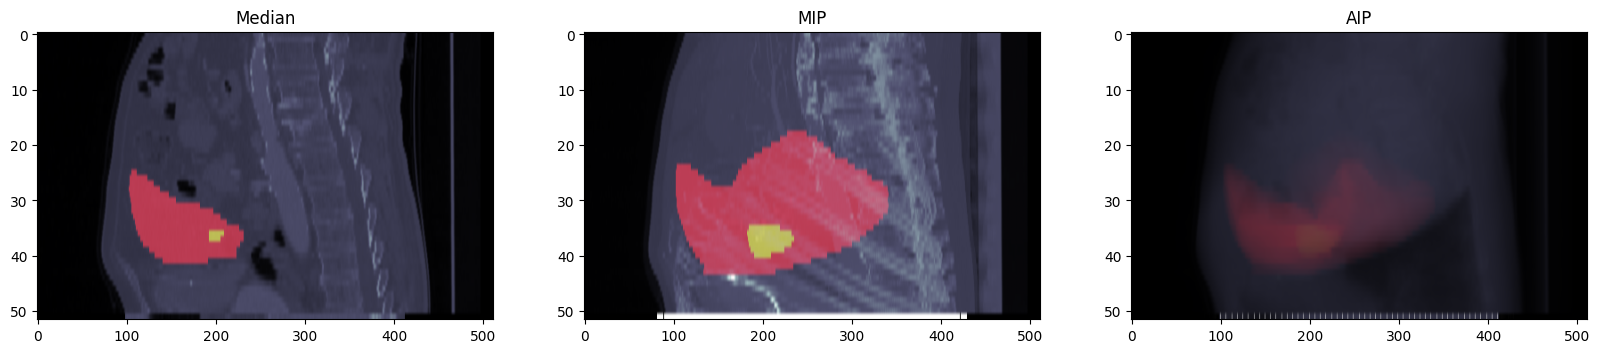

In [280]:
# Sagittal planes
# Show MIP/AIP/Median planes
plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.imshow(median_sagittal_plane(fused_volume), cmap=matplotlib.colormaps['bone'], aspect=pixel_dims[0]/pixel_dims[1])
plt.title('Median')

plt.subplot(1, 3, 2)
plt.imshow(MIP_sagittal_plane(fused_volume), cmap=matplotlib.colormaps['bone'], aspect=pixel_dims[0]/pixel_dims[1])
plt.title('MIP')

plt.subplot(1, 3, 3)
plt.imshow(AIP_sagittal_plane(fused_volume), cmap=matplotlib.colormaps['bone'], aspect=pixel_dims[0]/pixel_dims[1])
plt.title('AIP')
plt.show()

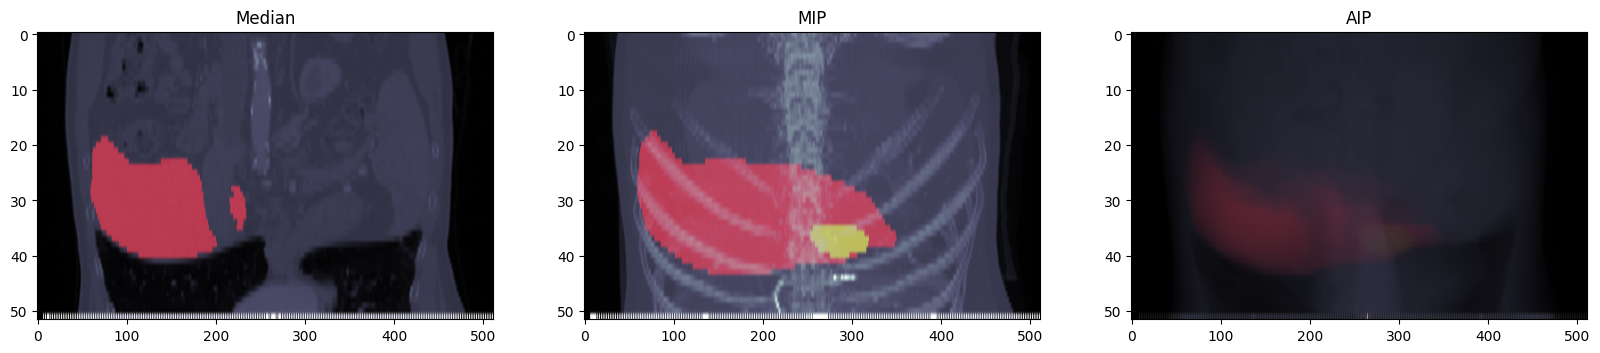

In [269]:
# Coronal planes
# Show MIP/AIP/Median planes
plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.imshow(median_coronal_plane(fused_volume), cmap=matplotlib.colormaps['bone'], aspect=pixel_dims[0]/pixel_dims[1])
plt.title('Median')

plt.subplot(1, 3, 2)
plt.imshow(MIP_coronal_plane(fused_volume), cmap=matplotlib.colormaps['bone'], aspect=pixel_dims[0]/pixel_dims[1])
plt.title('MIP')

plt.subplot(1, 3, 3)
plt.imshow(AIP_coronal_plane(fused_volume), cmap=matplotlib.colormaps['bone'], aspect=pixel_dims[0]/pixel_dims[1])
plt.title('AIP')
plt.show()

# Step 7: Create Projections Varying the Angle of Rotation on Sagittal Plane

This code generates a rotating MIP (Maximum Intensity Projection) from multiple perspectives along the sagittal plane and compiles these projections into an animated GIF. The animation allows for visualizing how different structures appear when rotated, providing a clearer understanding of their 3D positioning and relationships

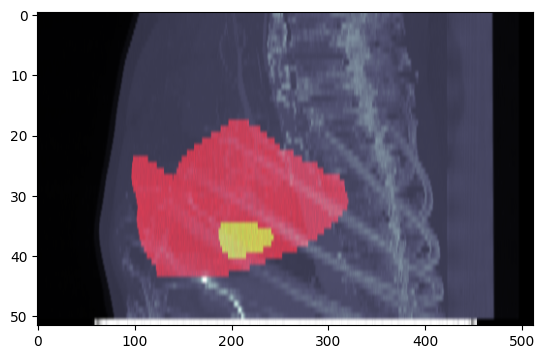

In [ ]:
# Initialize parameters for image min, max values and colormap
img_min = np.amin(fused_volume)
img_max = np.amax(fused_volume)
cm = matplotlib.colormaps["bone"]

fig, ax = plt.subplots()
os.makedirs("results/MIP/Sagittal/", exist_ok=True)

# Define the number of projections
n = 36
projections = []

# Loop through angles (from 0 to 360 degrees, divided into n steps)
for idx, alpha in enumerate(np.linspace(0, 360 * (n - 1) / n, num=n)):

    # Rotate the volume along the axial plane (around Z-axis)
    rotated_img = rotate_on_axial_plane(fused_volume, alpha)

    # Generate the Maximum Intensity Projection (MIP) along the sagittal plane
    projection = MIP_sagittal_plane(rotated_img)

    projection = np.clip(projection, 0, 1)

    plt.imshow( projection, cmap=matplotlib.colormaps["bone"],  aspect=pixel_dims[0] / pixel_dims[1] )

    plt.savefig(f"results/MIP/Sagittal/Projection_{idx}.png")

    # Add the projection to the list of projections
    projections.append(projection)

# Create an animation using the saved projections
animation_data = [
    [
        ax.imshow( img, animated=True, cmap=cm,  aspect=pixel_dims[0] / pixel_dims[1] )
    ]
    for img in projections
]

# Create the animation with 150ms interval between frames, enabling animation (blit=True)
anim = animation.ArtistAnimation(fig, animation_data, interval=150, blit=True)
anim.save("results/MIP/Sagittal/Animation.gif")
plt.show()

# Conclusion

This pipeline processes and visualizes 3D medical imaging data by loading DICOM CT slices and segmentation masks (liver and tumor), aligning them into a coherent 3D volume. It extracts and fuses segmentation data with the CT scan, generating dynamic visualizations such as Maximum Intensity Projections (MIP) and Average Intensity Projections (AIP) in different planes, including rotating MIP animations. These visualizations provide clear insights into the spatial distribution of anatomical features.